<a href="https://colab.research.google.com/github/vladimir-sashin/Recsys-course-homework/blob/master/RecSysLab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown --id 1Em-UZriSKRwCPahc5yLaaPPE3eESaa7S

Downloading...
From: https://drive.google.com/uc?id=1Em-UZriSKRwCPahc5yLaaPPE3eESaa7S
To: /content/data.csv
100% 2.47G/2.47G [00:29<00:00, 84.5MB/s]


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
from IPython.display import display

In [2]:
df = pd.read_csv("data.csv")
df.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,0,1240,0.067,0.035016,-7.268846,0,0.010,0.049516,-5.369901,1,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,0,1,1,0.002,0.054298,-2.657477,269,0.004,0.031942,-4.449220,1,1
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,3,0,0,2,0.014,0.014096,-3.824875,21,0.014,0.014906,-3.939309,1,1
3,2021-09-27 00:04:30.000000,3,3,6262169206735077204,0,1,1,3,0.012,0.015232,-3.461357,99,0.006,0.050671,-3.418403,1,1
4,2021-09-27 00:06:21.000000,4,4,4778985830203613115,0,1,0,4,0.019,0.051265,-4.009026,11464230,6.790,0.032005,-2.828797,1,1


# Подготовка и анализ данных

Произведем предобработку данных:
1. Удалим ненужные столбцы
2. Преобразуем тип данных столбца date_time к datetime, чтобы произвести разбиение на обучающую и тестовую выборку
3. Выведем максимальную и минимальную даты, чтобы понять, с каким периодом времени мы работаем
4. Отсортируем датасет по дате/времени и разобъем данные на train и test сеты. Test - показы рекламы в последний день, train - все остальные.

In [3]:
df = df.drop(["oaid_hash", "banner_id0", "banner_id1", "rate0", "rate1", "g0",
              "g1", "coeff_sum0", "coeff_sum1", "impressions"], axis=1)

df["date_time"] = pd.to_datetime(df.date_time)
df = df.sort_values("date_time")
min_date = df["date_time"][0].date()
max_date = df["date_time"].iloc[-1].date()
print("Min date: {}, Max date: {}".format(min_date, max_date))

df_test = df[(df['date_time'].dt.date == max_date)]
df = df[(df['date_time'].dt.date < max_date)]

Min date: 2021-09-27, Max date: 2021-10-02


Первоначальный анализ и всю последующую обработку будем производить только на обучающей выборке, а на test просто применим те же трансформации, чтобы не допустить data leakage. 


,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,clicks
1390198,2021-09-01 00:02:49,30,596,0,0,7,0
5041415,2021-09-26 00:00:00,41,29,1,3,0,0
1442602,2021-09-26 00:00:00,1,188,2,2,15,0
7232498,2021-09-26 00:00:00,17,52,2,2,5,0
14938691,2021-09-26 00:00:00,47,73,1,4,13,0


Traint set shape: (13692494, 7)



'Basic descriptive stats:'

,zone_id,banner_id,campaign_clicks,os_id,country_id,clicks
count,1.369249e+07,1.369249e+07,1.369249e+07,1.369249e+07,1.369249e+07,1.369249e+07
mean,7.963734e+01,3.742884e+02,6.520605e-01,1.833020e+00,4.392995e+00,2.533410e-02
std,1.579125e+02,3.926496e+02,9.629881e+00,1.512653e+00,4.329281e+00,1.571378e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.400000e+01,4.900000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,1.900000e+01,2.050000e+02,0.000000e+00,2.000000e+00,4.000000e+00,0.000000e+00
75%,5.900000e+01,6.100000e+02,0.000000e+00,3.000000e+00,7.000000e+00,0.000000e+00
max,3.443000e+03,1.632000e+03,8.290000e+02,1.000000e+01,1.600000e+01,1.000000e+00


'Variables info'

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,clicks
Missing values,0,0,0,0,0,0,0
Data types,datetime64[ns],int64,int64,int64,int64,int64,int64
Unique values,518312,3330,1586,822,11,17,2



clicks barplot


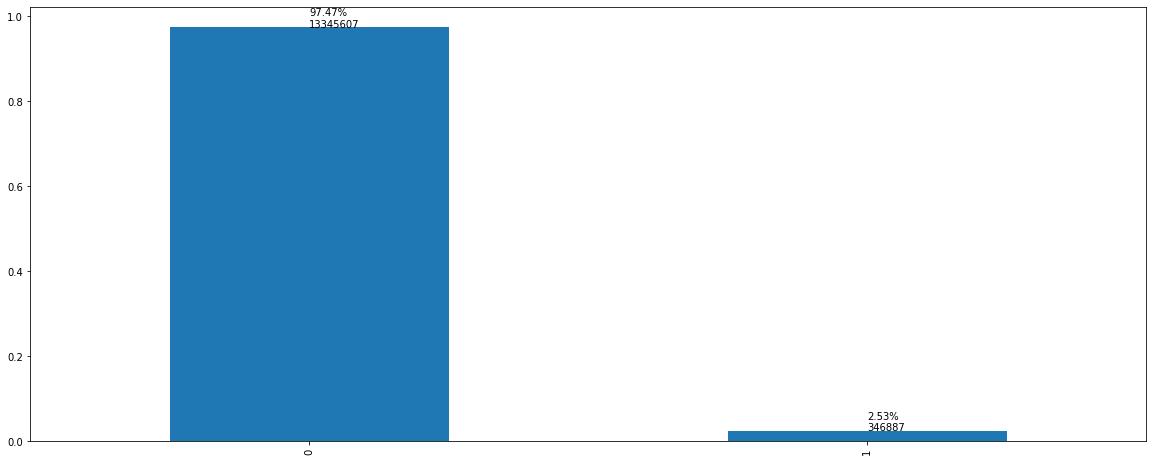


os_id barplot


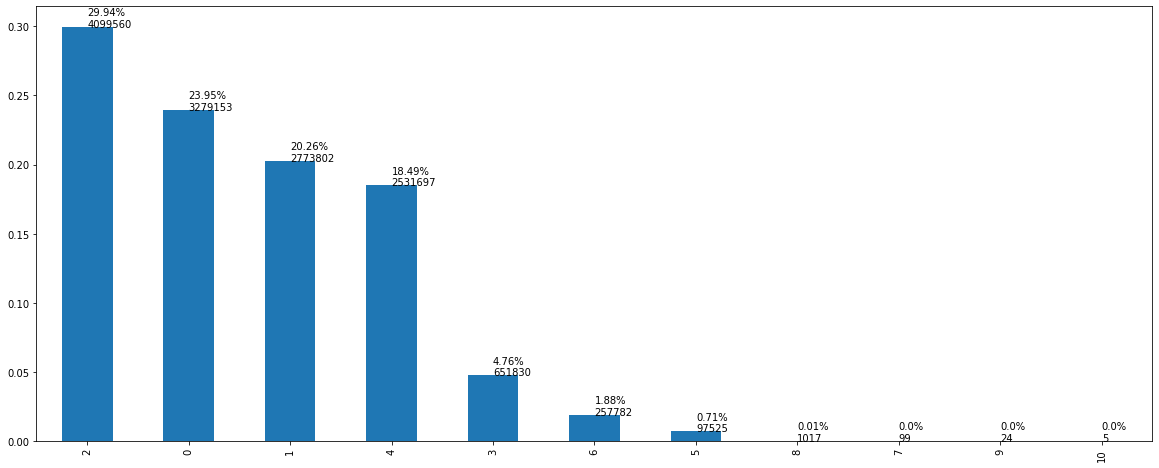


country_id barplot


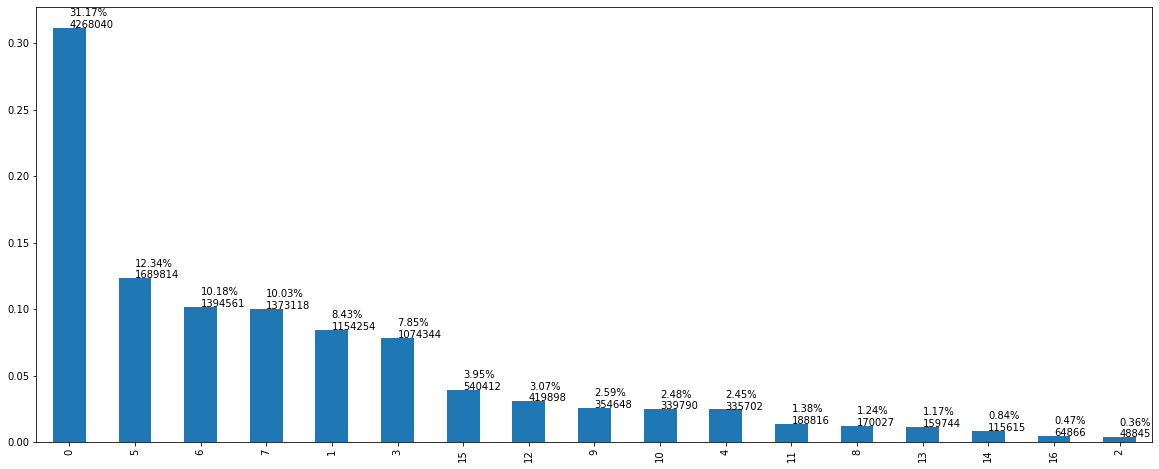


campaign_clicks barplot


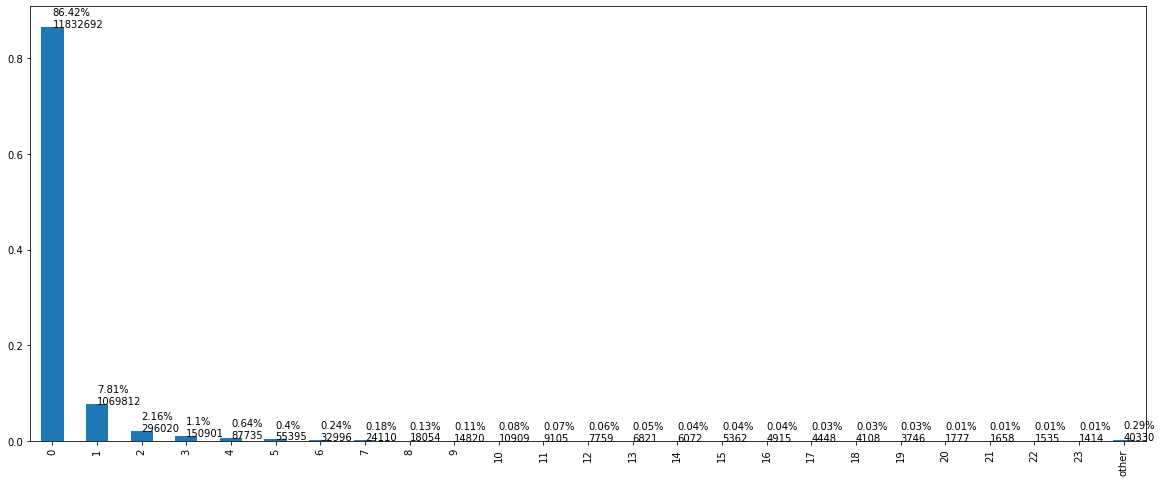

In [4]:
def barplot(df_column, threshold=None):
    plt.figure(figsize=(20,8))
    prob = df_column.value_counts(normalize=True)
    if threshold:
        mask = prob > threshold
        tail_prob = prob.loc[~mask].sum()
        prob = prob.loc[mask]
        prob['other'] = tail_prob
    prob.plot(kind='bar')
    # plt.xticks(rotation=25)
    for i, v in enumerate(prob.to_list()):
        plt.text(i, v, str(round(v*100, 2))+"%\n"+str(round(v*df.shape[0])))
        # plt.text(i, v + 0.005, str(v))
    plt.show()


def analyze(df):
    display(df.head())
    print("Traint set shape: {}".format(df.shape))
    print()

    display("Basic descriptive stats:", df.describe())
    print()

    data = [df.isna().sum().to_list(), df.dtypes.to_list(), df.nunique().to_list()]
    display("Variables info", pd.DataFrame(data, columns = df.columns.to_list(), index=["Missing values", "Data types", "Unique values"]))

    print("\nclicks barplot")
    barplot(df["clicks"])

    print("\nos_id barplot")
    barplot(df["os_id"])

    print("\ncountry_id barplot")
    # plt.show()
    barplot(df["country_id"])

    print("\ncampaign_clicks barplot")
    barplot(df["campaign_clicks"], threshold=0.0001)


analyze(df)

- Пропущенных значений нет, типы данных нужно будет поменять
- Выборка по исходу показа (клик/не клик) очень несбалансирована
- У нас есть множество категорий, на основании каждой из-которых по-отдельности мы вряд ли сможем построить нормальную модель, которая будет предсказывать вероятность клика. Есть очень маленькие категории ОС и стран, но их мало, поэтому убирать их не будем
- Чем больше количество предшествующих показов той же рекламной кампании, тем меньше количество наблюдений. Причем при подавляющем большинстве показов (более 86%) юзер ранее не видел ту же рекламную компанию, к которой относится показ, и лишь при 7.81% видел один раз, и при 1.1% - 3 раза, и так далее.

# Feature engineering

1. Количество предшествующих показов той же кампании, большее 23, объединим в отдельную категорию.
2. Из даты и времени показа вытащим две фичи - день недели и час
3. Сконструируем следующие интеракции, то есть создадим новые признаки показа из существующих путем их объединения:
- баннер, ОС, место на сайте - какой баннер, на какой платформе и в каком месте был показан
- баннер, страна, время - в какой стране и в какое время дня конкретный баннер был выведен при данном показе (таким образом учитываем различные таймзоны)
- день недели, баннер - какой баннер был показан в определенное время дня
- показы кампании, страна, баннер - сколько раз юзер из определенной страны видел кампанию, к которой принадлежит показанный ему баннер
- баннер, страна - какой баннер в какой стране показывается
- баннер, место на сайте - какой баннер в каком месте сайта показывается
- день недели - просто в какой день недели был произведен показ
4. Уберем лишние столбцы
5. Отделим предикторы от отклика
6. Изменим типы данных предикторов


In [5]:
def feature_engineering(df):
    df.loc[df.campaign_clicks > 23, "campaign_clicks"] = 24

    df["dayoftheweek"] = df["date_time"].dt.dayofweek
    df['hour'] = df["date_time"].dt.hour

    df['banner_os_zone'] = (df['banner_id'].astype('str') + '_' + df['os_id'].astype('str') + '_' + df['zone_id'].astype('str')).astype('category')
    df['banner_country_time'] = (df['banner_id'].astype('str') + '_' + df['country_id'].astype('str') + '_' + df['hour'].astype('str')).astype('category')
    df['banner_weekday'] = (df['banner_id'].astype('str') + '_' + df['dayoftheweek'].astype('str')).astype('category')
    df['campaign_shows_country_banner'] = (df['campaign_clicks'].astype('str') + '_' + df['country_id'].astype('str') + '_' + df['banner_id'].astype('str')).astype('category')
    df['banner_country'] = (df['banner_id'].astype('str') + '_' + df['country_id'].astype('str')).astype('category')
    df['banner_zone'] = (df['banner_id'].astype('str') + '_' + df['zone_id'].astype('str')).astype('category')
    df["dayoftheweek"] = df["dayoftheweek"].astype("category")

    df = df.drop(["date_time", "zone_id", "banner_id", "os_id", "country_id", "hour", "campaign_clicks"], axis=1)
    

    y = df["clicks"].values
    df = df.drop(["clicks"], axis=1)

    categorical_feature_mask = df.dtypes == "category"
    categorical_cols = df.columns[categorical_feature_mask].tolist()
    return df, y, categorical_cols


df, y, categorical_cols = feature_engineering(df)

In [6]:
df.shape, y.shape

((13692494, 7), (13692494,))

In [7]:
df.head()

,dayoftheweek,banner_os_zone,banner_country_time,banner_weekday,campaign_shows_country_banner,banner_country,banner_zone
1390198,2,596_0_30,596_7_0,596_2,0_7_596,596_7,596_30
5041415,6,29_3_41,29_0_0,29_6,1_0_29,29_0,29_41
1442602,6,188_2_1,188_15_0,188_6,2_15_188,188_15,188_1
7232498,6,52_2_17,52_5_0,52_6,2_5_52,52_5,52_17
14938691,6,73_4_47,73_13_0,73_6,1_13_73,73_13,73_47


Произведем one-hot encoding всех наших фичей. Будем фитить класс OneHotEncoder из sklearn, чтобы потом получить те же столбцы и на тестовом сете, при этом установим sparse=True, чтобы на выходе получить sparse матрицу в формате csr для более эффективной работы с данными

In [8]:
from sklearn.preprocessing import OneHotEncoder


ohe = OneHotEncoder(handle_unknown='ignore', sparse = True)
ohe.fit(df[categorical_cols])
df = ohe.transform(df[categorical_cols])
df

<13692494x594281 sparse matrix of type '<class 'numpy.float64'>'
	with 95847458 stored elements in Compressed Sparse Row format>

# Кросс-валидация и обучение

Обучать будем логистическую регрессию с оптимизатором liblinear и l2 регуляризацией. Чтобы подобрать гиперпараметр регуляризации, проведем кросс-валидацию с разбиением на 3 подмножества, используя TimeSeriesSplit, чтобы тестовые данные всегда были позже по времени, чем обучающие. После того, как подберем гиперпараметр, обучим модель на целой тренировочной выборке

In [9]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from joblib import dump


model = LogisticRegression(random_state=42, penalty="l2", solver="liblinear")
param_search = {'C' : [0.0001, 0.001, 0.01, 0.1]}

splits = TimeSeriesSplit(n_splits=3)
gsearch = GridSearchCV(estimator=model, cv=splits,
                        param_grid=param_search, verbose=2, scoring="neg_log_loss")
gsearch.fit(df, y)

print(gsearch.cv_results_)

best_model = gsearch.best_estimator_
print("Best score: {} \nBest params: {}".format(gsearch.best_score_, gsearch.best_params_))

dump(best_model, 'new_model.joblib')

best_model.fit(df, y)
dump(best_model, 'fit_model_new.joblib') 

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......................................... C=0.0001, total=  11.6s
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.6s remaining:    0.0s


[CV] ......................................... C=0.0001, total=  21.3s
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=  33.7s
[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=  15.3s
[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=  30.8s
[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=  54.1s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=  24.8s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total= 1.0min
[CV] C=0.01 ..........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 13.3min finished


{'mean_fit_time': array([ 20.8639756 ,  32.06320659,  66.5434037 , 141.14885084]), 'std_fit_time': array([ 8.99441466, 15.85470065, 37.80323862, 78.18100022]), 'mean_score_time': array([1.3237234 , 1.31984194, 1.36007158, 1.36810867]), 'std_score_time': array([0.0757119 , 0.11266217, 0.12722772, 0.10244281]), 'param_C': masked_array(data=[0.0001, 0.001, 0.01, 0.1],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.0001}, {'C': 0.001}, {'C': 0.01}, {'C': 0.1}], 'split0_test_score': array([-0.11536068, -0.09956258, -0.0954665 , -0.09387765]), 'split1_test_score': array([-0.12455319, -0.11881404, -0.11599626, -0.11485974]), 'split2_test_score': array([-0.16212776, -0.15617695, -0.15000648, -0.14715517]), 'mean_test_score': array([-0.13401388, -0.12485119, -0.12048975, -0.11863085]), 'std_test_score': array([0.02023065, 0.02350365, 0.02249142, 0.02191331]), 'rank_test_score': array([4, 3, 2, 1], dtype=int32)}
Best score: -0

['fit_model_new.joblib']

# Трансформация тестового множества, получение предсказаний и оценка Logloss

In [10]:
df = df_test
df, y, categorical_cols = feature_engineering(df)

df = ohe.transform(df[categorical_cols])
df

<2128978x594281 sparse matrix of type '<class 'numpy.float64'>'
	with 9654195 stored elements in Compressed Sparse Row format>

In [11]:
from sklearn.metrics import log_loss


predictions = best_model.predict_proba(df)
log_loss(y, predictions)

0.1347992130474668

Сравним logloss нашей модели на тесте с логлоссом случайного угадывания на этом же множестве с учетом несбалансированности классов.

Посчитаем соотношение классов на тесте:

In [19]:
pd.Series(y).value_counts(normalize=True)

0    0.964602
1    0.035398
dtype: float64

И количество объектов:

In [20]:
len(y)

2128978

Logloss случайного угадывания на тест сете:

In [30]:
def random_guess_log_loss(class_ratio, objects_number=10000):
    actuals=[]
    for i,val in enumerate(class_ratio):
        actuals.extend([i for x in range(round(val*objects_number))])
    preds=[]
    for i in range(objects_number):
        preds+=[class_ratio]

    return (log_loss(actuals, preds))

random_guess_log_loss([0.035398, 0.964602], objects_number=2128978)

0.15303289904980513

Как видим, logloss нашей модели лучше случайного угадывания

In [32]:
log_loss(y, y)

9.99200722162641e-16